In [ ]:
from zumi.zumi import Zumi
from zumi.util.screen import Screen
import time
from datetime import datetime
from zumi.util.vision import Vision
from zumi.util.camera import Camera 
from zumi.personality import Personality
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

zumi =    Zumi()
camera    = Camera()
screen    = Screen()
vision    = Vision()
personality = Personality(zumi, screen)

In [3]:
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
zumi.get_battery_percent()

In [ ]:
zumi.mpu.calibrate_MPU()

In [ ]:
log = {}
def line_correction(bottom_left, bottom_right, desired_angle, threshold):
    if bottom_left > threshold and bottom_right < threshold:
        desired_angle +=5
        zumi.stop()
        time.sleep(0.01) 
    elif bottom_left < threshold and bottom_right > threshold:
        desired_angle -=5
        zumi.stop()
        time.sleep(0.01) 
    return desired_angle

def turning_correction(desired_angle, turn_angle):
    if desired_angle >= -turn_angle if desired_angle<0 else turn_angle:
        desired_angle = -abs(turn_angle-abs(desired_angle))
    else:
        desired_angle = abs(turn_angle-abs(desired_angle))
    return desired_angle

def turn_to_check(turn, angle = 90):
    zumi.reset_gyro()
    if turn == 'left':
        zumi.signal_left_on()
        zumi.turn_left(angle)
        zumi.signal_left_off()
    elif turn == 'right':
        zumi.signal_right_on()
        zumi.turn_right(2*angle)
        zumi.signal_right_off()
    time.sleep(0.01)
    desired_angle = zumi.read_z_angle()
    return desired_angle

def move_after_turning(speed, desired_angle, times=3):
    zumi.reset_gyro() 
    for x in range(times):
        zumi.go_straight(speed, desired_angle)
    zumi.stop()

def object_detected(threshold=100):
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data() # Get center IR sensor value
    
    return front_right < threshold and front_left < threshold

def log_event(action):
    timestamp = datetime.now()
    log[action] = log.setdefault(action, [])
    log[action].append(timestamp)

def circle(turn, number_of_objects, threshold, speed=4):
    log_event("start "+ turn+ " circle")
    zumi.reset_gyro()
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, 0)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    for j in range(number_of_objects):
        for i in range(4):
            zumi.reset_gyro()
            if turn == 'left':
                zumi.signal_left_on()
                zumi.turn_left(90)
                zumi.signal_left_off()
                log_event('move_left')
            elif turn == 'right':
                zumi.signal_right_on()
                zumi.turn_right(90)
                zumi.signal_right_off()
                log_event('move_right')
            desired_angle = zumi.read_z_angle()
            desired_angle = turning_correction(desired_angle, 90)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.reset_gyro()
            while bottom_left > threshold or bottom_right > threshold:
                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
                desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
                zumi.go_straight(speed, desired_angle)
            zumi.stop()
    log_event("done "+ turn+ " circle")

def find_the_finish_line():
    speed = 3
    threshold = 100
    zumi.reset_gyro()

    turned_left_angle = turn_to_check('left', 80)
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
    if bottom_left > threshold and bottom_right > threshold:
        print("line left")
        while (bottom_left > threshold and bottom_right > threshold):
            zumi.turn_right(5)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        zumi.reset_gyro()
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, 0)
            if bottom_right > threshold and bottom_left > threshold:
                zumi.stop()
                break
        
        move_after_turning(speed, 0, 15)
        zumi.turn_right(25)
    else:
        print("no line left")
        turned_right_angle = turn_to_check('right', 80)        
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        while (bottom_left > threshold and bottom_right > threshold):
            zumi.turn_left(5)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        zumi.reset_gyro()
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, 0)
            if bottom_right > threshold and bottom_left > threshold:
                print("line found")
                zumi.stop()
                break
        
        move_after_turning(speed, 0, 15)
        
        zumi.turn_left(25)
    zumi.reset_gyro()
    
def find_line(angle_to_turn):
    zumi.reset_gyro()
    speed = 5
    threshold = 100
    # Move if sitll on line
    
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    # Move to find new line
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right > threshold and bottom_left > threshold:
            zumi.stop()
            break
    log_event("again_on_line")

    start_time = time.time()
    while True:
        if time.time() - start_time > 1:
            zumi.stop()
            print("time is out")
            break
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break

    log_event("out_of_line")
    if (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 0.3 :
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right > threshold and bottom_left > threshold:
                zumi.stop()
                break
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right < threshold and bottom_left < threshold:
                zumi.stop()
                break

        move_after_turning(speed, 0, 3)
        find_the_finish_line()
    elif (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 1:
        print("find_line_2")
        move_after_turning(speed, 0, 3)
        find_the_finish_line()


def dance_360(turn, times):
    if turn == 'left':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_left_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_left(angle_to_turn)
                angle_to_turn = 360 - zumi.read_z_angle()
            zumi.signal_left_off()
            zumi.stop()
        return angle_to_turn
    elif turn == 'right':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_right_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_right(angle_to_turn)
                angle_to_turn = 360 + zumi.read_z_angle()
            zumi.signal_right_off()
            zumi.stop()
        return angle_to_turn

def what_after_object(speed, number_of_objects, number_of_faces, threshold):
    number_of_turns = number_of_objects - number_of_faces
    camera.start_camera()
    for _ in range(5):
        frame = camera.capture()
        camera.show_image(frame)
        qr_code = vision.find_QR_code(frame)
        message = vision.get_QR_message(qr_code)
        if message != None:
            camera.close()
            screen.draw_text_center("QR Code Detected!")
            log_event("qr_code_command:"+ str(message))
            print("QR code detected!")
            qr_code_command(message, speed, number_of_turns , threshold)
            log_event("qr_code_command:"+ str(message) +"done")
            break
        gray_picture = vision.convert_to_gray(frame)
        faces= vision.find_face(gray_picture)
        if faces != None:
            camera.close()
            screen.draw_text_center("Face Detected!")
            log_event("face_detected")
            print("Face detected!")
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = str(timestamp)+".png"
            cv2.imwrite(filename, gray_picture)
            number_of_faces += 1
            log_event('face_count: ' + str(number_of_faces))
            break
        time.sleep(1)
    camera.close()
    return number_of_faces

def qr_code_command(message, speed, number_of_turns, threshold):
    print("QR code message: ", message)
    if message == "Left Circle":
        circle('left', number_of_turns, threshold)
    elif message == "Right Circle":
        circle('right', number_of_turns, threshold)
    elif message == "Turn Left":
        zumi.signal_left_on()
        zumi.turn_left(90)
        zumi.signal_left_off()
    elif message == "Turn Right":
        zumi.signal_right_on()
        zumi.turn_right(90)
        zumi.signal_right_off()
    elif message == "Stop":
        zumi.stop()
    elif message == "Zumi is happy today!":
        personality.happy()
    elif message == "Zumi is angry today!":
        personality.angry()
    elif message == "Zumi is celebrating today!":
        personality.celebrate()
    elif "360" in str(message):

        spin_message = message.split(" ")
        times = int(spin_message[0])
        turn = spin_message[3][:-1]
        emotion = spin_message[-1]

        print("turn", turn)
        angle_to_turn = dance_360(turn, times)*2

        if emotion == "happy":
            personality.happy()
        elif emotion == "angry":
            personality.angry()
        elif emotion == "celebrating":
            personality.celebrate()
        zumi.stop()
        
        print("Angle to turn: ", angle_to_turn)
        find_line(angle_to_turn)
    else:
        print("Invalid command")
        return "Invalid command"


def finish_with_180_turn():
    zumi.stop()
    log_event("finish")
    print("Reached end. Performing 180° turn.")
    screen.draw_text_center("Finisher box\nTurning 180°")
    zumi.turn_left(180)
    screen.draw_text_center("Done!")

def save_dict_to_csv(data_dict):
    # Generate file name with current time
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = "Zumi7337_output_" + current_time + ".csv"

    # Create empty list to store rows
    rows = []

    # Go through all actions and timestamps
    for action, timestamps in data_dict.items():
        for timestamp in timestamps:
            # Add row to list of rows
            rows.append({"timestamp": timestamp, "action": action})

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows)

    # Sort DataFrame by column timestamp
    df = df.sort_values(by='timestamp')

    # Calculate run time
    if 'start' in data_dict and 'stop' in data_dict:
        start_time = data_dict['start'][0]
        stop_time = data_dict['stop'][-1]
        runtime = stop_time - start_time
        # Append as a new row
        df = pd.concat([df, pd.DataFrame([{
            'timestamp': stop_time,
            'action': 'run_time: ' + str(runtime)
        }])], ignore_index=True)

    # Save DataFrame in CSV file
    df.to_csv(file_name, index=False)
    print("Data saved in ", file_name)

In [17]:
#testing csv file
df = pd.read_csv(r'C:\Source\Python\robot_challenge\submissions\03.06.2025\Zumi7337_output_20250603_094833.csv', delimiter=',') 
df2 = pd.read_csv(r'C:\Source\Python\robot_challenge\submissions\03.06.2025\Zumi7337_output_20250603_124256.csv', delimiter=',')

print(df2)

                      action                   timestamp
0                      start  2025-06-03 12:40:12.898990
1                   end_line  2025-06-03 12:40:12.900007
2                   end_line  2025-06-03 12:40:19.751744
3                 check_left  2025-06-03 12:40:19.751993
4                check_right  2025-06-03 12:40:20.862284
..                       ...                         ...
67                      stop  2025-06-03 12:42:54.703183
68                    finish  2025-06-03 12:42:54.714703
69      finish_with_180_turn  2025-06-03 12:42:56.334805
70                      stop  2025-06-03 12:42:56.345869
71  run_time: 0:02:43.446879  2025-06-03 12:42:56.345869

[72 rows x 2 columns]


In [35]:
def extract_movement_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    movement_starts = {'start', 'continuing_driving', 'move_right', 'move_left'}
    interrupts = {'object_detected', 'end_line'}
    DIRECTIONS = ['north', 'east', 'south', 'west']
    current_direction_index = 3  # Start facing west

    movements = []
    i = 0
    while i < len(df):
        action = df.loc[i, 'action']

        # Circle handling
        if action == 'start right circle':
            circle_start_time = df.loc[i, 'timestamp']
            circle_start_direction = DIRECTIONS[current_direction_index]
            move_right_times = []
            i += 1

            while i < len(df):
                circle_action = df.loc[i, 'action']
                circle_time = df.loc[i, 'timestamp']

                if circle_action == 'move_right':
                    current_direction_index = (current_direction_index + 1) % 4
                    move_right_times.append(circle_time)

                if circle_action == 'finish right circle':
                    circle_end_time = circle_time
                    duration = (circle_end_time - circle_start_time).total_seconds()

                    # Calculate segment durations
                    segment_durations = [
                        (move_right_times[j] - move_right_times[j - 1]).total_seconds()
                        for j in range(1, len(move_right_times))
                    ]
                    avg_side_duration = sum(segment_durations) / len(segment_durations) if segment_durations else None
                    side_count = len(move_right_times)
                    loop_count = side_count / 4 if side_count else 0
                    avg_loop_duration = duration / loop_count if loop_count else None

                    movements.append({
                        'start_time': circle_start_time,
                        'interrupt_time': circle_end_time,
                        'facing_direction': circle_start_direction,
                        'movement_duration_seconds': duration,
                        'start_action': 'circle_right',
                        'average_side_duration': avg_side_duration,
                        'side_count': side_count,
                        'loop_count': loop_count,
                        'average_loop_duration': avg_loop_duration
                    })
                    i += 1
                    break
                i += 1
            continue

        # Track direction changes
        if action == 'move_right':
            current_direction_index = (current_direction_index + 1) % 4
        elif action == 'move_left':
            current_direction_index = (current_direction_index - 1) % 4

        # Standard movement logic
        if action in movement_starts:
            start_time = df.loc[i, 'timestamp']
            start_action = action
            facing_direction = DIRECTIONS[current_direction_index]
            i += 1

            while i < len(df):
                current_action = df.loc[i, 'action']
                current_time = df.loc[i, 'timestamp']

                if current_action == 'move_right':
                    current_direction_index = (current_direction_index + 1) % 4
                elif current_action == 'move_left':
                    current_direction_index = (current_direction_index - 1) % 4

                if current_action in interrupts:
                    if current_action == 'end_line' and i + 1 < len(df) and df.loc[i + 1, 'action'] == 'end_line':
                        interrupt_time = df.loc[i + 1, 'timestamp']
                        i += 2
                    else:
                        interrupt_time = current_time
                        i += 1
                    break

                i += 1

            if 'interrupt_time' in locals():
                duration = (interrupt_time - start_time).total_seconds()
                movements.append({
                    'start_time': start_time,
                    'interrupt_time': interrupt_time,
                    'facing_direction': facing_direction,
                    'movement_duration_seconds': duration,
                    'start_action': start_action
                })
                del interrupt_time

        else:
            i += 1

    return pd.DataFrame(movements)


def manhattan_distance(df):
    grid = np.zeros((600, 600), dtype=int)
    x, y = 300, 300  # Start in center
    grid[y, x] = 1   # Mark starting point

    DIRECTIONS = ['north', 'east', 'south', 'west']
    MOVE = {
        'north': (0, -1),
        'east': (1, 0),
        'south': (0, 1),
        'west': (-1, 0)
    }

    current_direction_index = 3  # Start facing west
    step = 2

    for _, row in df.iterrows():
        start_action = row['start_action']

        if start_action == 'circle_right':
            side_count = int(row.get('side_count', 4))
            avg_side_duration = row.get('average_side_duration', 1)

            # Walk each side of the circle
            for _ in range(side_count):
                current_direction_index = (current_direction_index + 1) % 4
                direction = DIRECTIONS[current_direction_index]
                dx, dy = MOVE[direction]
                steps = int(round(avg_side_duration))  # seconds → steps

                for _ in range(steps):
                    x += dx
                    y += dy
                    if 0 <= x < 600 and 0 <= y < 600:
                        grid[y, x] = step
                        step += 1
        else:
            direction = row['facing_direction']
            dx, dy = MOVE[direction]
            steps = int(round(row['movement_duration_seconds']))

            for _ in range(steps):
                x += dx
                y += dy
                if 0 <= x < 600 and 0 <= y < 600:
                    grid[y, x] = step
                    step += 1

    return grid


def plot_path(grid):
    y_coords, x_coords = np.nonzero(grid)

    if len(x_coords) == 0 or len(y_coords) == 0:
        print("No movement found to plot.")
        return

    margin = 5
    xmin, xmax = max(0, x_coords.min() - margin), min(600, x_coords.max() + margin + 1)
    ymin, ymax = max(0, y_coords.min() - margin), min(600, y_coords.max() + margin + 1)

    # Crop the grid
    cropped = grid[ymin:ymax, xmin:xmax]

    # Shift coordinates so (300, 300) becomes (0, 0)
    x_shift = 300
    y_shift = 300
    xmin_shifted = xmin - x_shift
    xmax_shifted = xmax - x_shift
    ymin_shifted = ymin - y_shift
    ymax_shifted = ymax - y_shift

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(
        cropped > 0,  # convert to binary (True/False) for path
        cmap='Greys',  # black path on white background
        origin='upper',
        extent=[xmin_shifted, xmax_shifted, ymax_shifted, ymin_shifted]
    )

    plt.title("Zumi Movement Path")
    plt.xlabel('X offset from start (seconds)')
    plt.ylabel('Y offset from start (seconds)')
    plt.gca().set_aspect('equal')

    # Clean, square grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    plt.xticks(np.arange(xmin_shifted, xmax_shifted + 1, 1))
    plt.yticks(np.arange(ymin_shifted, ymax_shifted + 1, 1))

    plt.gca().set_facecolor('white')  # ensure background is white
    plt.tight_layout()
    plt.show()

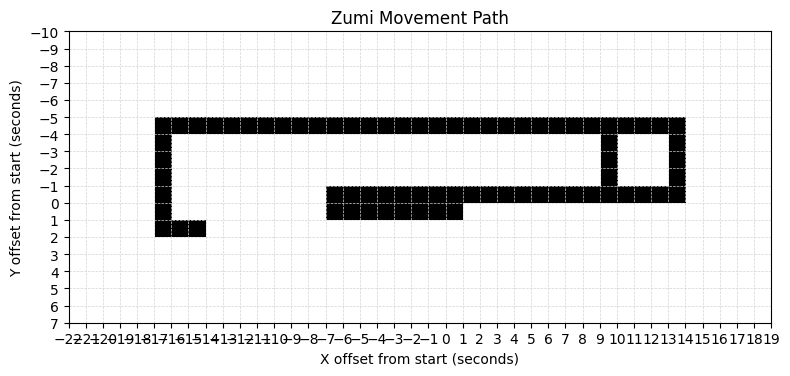

In [36]:
df_movement = extract_movement_data(df2)
grid = manhattan_distance(df_movement)
plot_path(grid)


In [ ]:
log = {}
zumi.reset_gyro()
desired_angle = zumi.read_z_angle() 
number_of_objects = 0
number_of_faces = 0

log_event('start')
log_event('end_line')
time.sleep(1)

try:
    while True:
        # Set the threshold for the IR sensors and the speed
        threshold = 50 
        speed = 5

        if object_detected():
            zumi.stop()

            zumi.play_note(1, 500) # 1 is note type (1 - 60), 500 is duration in ms
            log_event('object_detected')
            screen.draw_text_center("Object detected") #Message that object was detected
            print("Waiting for object to be removed...")
            
            zumi.brake_lights_on()
            while object_detected():
                zumi.stop()
                time.sleep(0.1)
            zumi.brake_lights_off()
            
            number_of_objects += 1

            log_event('object_removed')
            log_event('object_count: ' + str(number_of_objects))
            print("Object removed. Resuming movement.")
            log_event('loking for qr_code of face')
            
            number_of_faces = what_after_object(speed, number_of_objects, number_of_faces, threshold)
            
            log_event('continue_moving_after_object')
        
        
        if any("Zumi is" in key for key in log):
            zumi.stop()
            log_event('stop')
            finish_with_180_turn()
            log_event('finish_with_180_turn')
            break
            

        # Read all IR sensor values
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        # Correction to line if one sensor is on the line and the other is off
        desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
        time.sleep(0.01) 
        print("desired_angle:", desired_angle)
        # Move forward with the corrected heading
        if bottom_left > threshold or bottom_right > threshold:
            zumi.go_straight(speed, desired_angle)
        else:
            log_event('end_line')
            if "done right circle" in log:
                if (datetime.now() - log['done right circle'][-1]).total_seconds() < 3:
                    zumi.stop()
                    time.sleep(3)
                    log['finish right circle'] = log.pop('done right circle')
            elif "done left circle" in log:
                if(datetime.now() - log['done left circle'][-1]).total_seconds() < 3:  
                    zumi.stop()
                    time.sleep(3) 
                    log['finish left circle'] = log.pop('done left circle')
            if (log['end_line'][-1] - log['end_line'][-2]).total_seconds() > 3:
                go_left = True
            
                log_event('check_left')
                # Turn to check if left is line
                turned_left_angle = turn_to_check('left')

                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_left_angle, 90)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            else:
                go_left = False
            if (bottom_left > threshold or bottom_right > threshold) and go_left:
                log_event('move_left')
                move_after_turning(speed, desired_angle)
            else:
                
                log_event('check_right')
                # Turn to check if right is line
                turned_right_angle = turn_to_check('right') 
                
                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_right_angle, 180)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

                if bottom_left > threshold or bottom_right > threshold:
                    log_event('move_right')
                    move_after_turning(speed, desired_angle)
                else:
                    desired_angle = turn_to_check('left')
                    while (bottom_left < threshold or bottom_right < threshold):
                        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
                        zumi.go_reverse(speed, desired_angle)

finally:
    zumi.stop()
    log_event('stop')
    save_dict_to_csv(log)